# Intent Classification using Keras

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Leonardo
[nltk_data]     W\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Data Processing - Main
import numpy as np
import pandas as pd
import re

# Data Processing - Tokenizer and Encoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from sklearn.preprocessing import OneHotEncoder

# Data Processing - Splitting
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

# Misc.
from datetime import datetime

In [3]:
# test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Sat Oct 31 19:19:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8     8W /  N/A |    191MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [5]:
RANDOM_SEED = 13517048
np.random.seed(RANDOM_SEED)

## Data Cleaning

In [6]:
data = pd.read_csv("nlu.csv")
data.head(10)

,text,intent
0,mau absen 11-14 februari 2020,absence
1,mau absen 11 - 14 februari 2020,absence
2,sick leave besok,absence
3,aku mau absence besok,absence
4,change working hours besok,absence
5,change working hour besok,absence
6,absen besok,absence
7,change working hours,absence
8,sick leave,absence
9,mau absen tanggal 10-11 januari 2012,absence


In [7]:
data['intent'].value_counts()

approval_status                        80
approval                               57
leave_entry                            54
approval_ask_parameter                 52
absence                                46
                                       ..
disable_push_notification_ask_type      2
enable_push_notification_ask_type       2
reimburse_ask_claimed_amount            2
default_fallback_intent                 1
leave_entry_half_day_ask_start_time     1
Name: intent, Length: 103, dtype: int64

### USE ONLY SOME DATA INTENTS

<b>Intents to use:</b>
- absence
- thankyou
- cancel
- help

In [8]:
data = data[data['intent'].isin(['absence', 'thank_you', 'cancel', 'help', 'default_fallback_intent'])]
data.head()

,text,intent
0,mau absen 11-14 februari 2020,absence
1,mau absen 11 - 14 februari 2020,absence
2,sick leave besok,absence
3,aku mau absence besok,absence
4,change working hours besok,absence


In [9]:
data['intent'].value_counts()

absence                    46
cancel                     33
thank_you                  22
help                       18
default_fallback_intent     1
Name: intent, dtype: int64

In [10]:
# Clean data:
#   - Strip data from special characters
#   - Tokenize words
#   - Lowercase all word
def clean_data(text_data):
  words = []
  for sentence in text_data:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", sentence)
    tokenized_words = word_tokenize(clean)

    words.append([word.lower() for word in tokenized_words])

  return words

In [11]:
# Get max length of every word in words
def get_max_length(words):
  return len(max(words, key = len))

In [12]:
filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'

def create_tokenizer(words):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [13]:
def create_train_data(text_data):
  # Encoding document
  token = create_tokenizer(text_data)
  sequences = token.texts_to_sequences(text_data)

  max_length = get_max_length(sequences)
  return pad_sequences(sequences, maxlen=max_length, padding="post")

In [14]:
def onehot_encode(data):
  encoder = OneHotEncoder(sparse=False)
  return encoder.fit_transform(data)

In [15]:
cleaned_data = clean_data(data['text'])

In [16]:
tokenizer = create_tokenizer(cleaned_data)
MAX_LENGTH = get_max_length(cleaned_data)
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [17]:
train_data = create_train_data(cleaned_data)
test_data = onehot_encode(data['intent'].values.reshape(-1, 1))

x_train, x_val, y_train, y_val = train_test_split(train_data, test_data, test_size = 0.2)

## Machine Learning Modeling

In [18]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 512, input_length=MAX_LENGTH, trainable=False))
model.add(Bidirectional(LSTM(512)))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(y_train.shape[1], activation = "softmax"))

In [19]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 512)           60928     
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1

### Model Train

In [20]:
# Fit constants

EPOCHS = [100]
BASIZE = [32]

Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 4s 47ms/sample - loss: 1.5697 - accuracy: 0.2917 - val_loss: 1.4446 - val_accuracy: 0.2917
Epoch 2/100
96/96 [==============================] - 0s 384us/sample - loss: 1.5101 - accuracy: 0.3229 - val_loss: 1.4081 - val_accuracy: 0.2917
Epoch 3/100
96/96 [==============================] - 0s 375us/sample - loss: 1.4652 - accuracy: 0.2708 - val_loss: 1.4163 - val_accuracy: 0.5417
Epoch 4/100
96/96 [==============================] - 0s 379us/sample - loss: 1.4263 - accuracy: 0.3438 - val_loss: 1.4130 - val_accuracy: 0.2917
Epoch 5/100
96/96 [==============================] - 0s 395us/sample - loss: 1.3930 - accuracy: 0.4062 - val_loss: 1.4368 - val_accuracy: 0.2917
Epoch 6/100
96/96 [==============================] - 0s 386us/sample - loss: 1.3654 - accuracy: 0.3854 - val_loss: 1.2973 - val_accuracy: 0.6250
Epoch 7/100
96/96 [==============================] - 0s 372us/sample - loss: 1.3268 - a

Epoch 57/100
96/96 [==============================] - 0s 349us/sample - loss: 0.0701 - accuracy: 0.9896 - val_loss: 0.8445 - val_accuracy: 0.8333
Epoch 58/100
96/96 [==============================] - 0s 349us/sample - loss: 0.0513 - accuracy: 0.9792 - val_loss: 0.8467 - val_accuracy: 0.8333
Epoch 59/100
96/96 [==============================] - 0s 338us/sample - loss: 0.0452 - accuracy: 1.0000 - val_loss: 0.8637 - val_accuracy: 0.8333
Epoch 60/100
96/96 [==============================] - 0s 354us/sample - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.8954 - val_accuracy: 0.8333
Epoch 61/100
96/96 [==============================] - 0s 338us/sample - loss: 0.0256 - accuracy: 1.0000 - val_loss: 0.9269 - val_accuracy: 0.8333
Epoch 62/100
96/96 [==============================] - 0s 363us/sample - loss: 0.0480 - accuracy: 0.9792 - val_loss: 0.9712 - val_accuracy: 0.8333
Epoch 63/100
96/96 [==============================] - 0s 351us/sample - loss: 0.0227 - accuracy: 0.9896 - val_loss: 1.0410 -

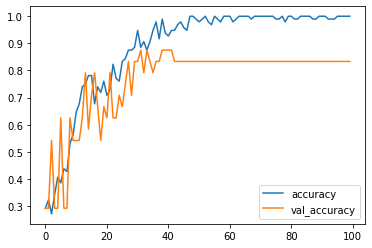

In [21]:
for ep, bs in zip(EPOCHS, BASIZE):
  history = model.fit(x_train, y_train, epochs=ep, batch_size=bs, validation_data=(x_val, y_val))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.legend(['accuracy', 'val_accuracy'])
  plt.show()

### Model Predict

In [22]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [23]:
intent_map = {}
for intent, onehot_intent in zip(data['intent'].values, test_data):
  if (intent not in intent_map):
    intent_map[intent] = list(onehot_intent).index(1)

In [24]:
intent_map

{'absence': 0,
 'cancel': 1,
 'help': 3,
 'default_fallback_intent': 2,
 'thank_you': 4}

In [25]:
def predict(text):
  # Clean the text first
  cleaned_text = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(cleaned_text)
  test_word = [w.lower() for w in test_word]
  test_ls = tokenizer.texts_to_sequences(test_word)

  # Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, MAX_LENGTH)
  prediction_result = model.predict(x)
  prediction_result = prediction_result[0]

  # convert prediction result to intent word
  unique_intents = intent_map.keys()

  # sort value by intent ranking
  intent_ranking = {}
  for each_intent in unique_intents:
    intent_ranking[each_intent] = prediction_result[intent_map[each_intent]]

  sorted_intent_ranking = sorted(intent_ranking.items(), key=lambda kv: kv[1], reverse=True)
  print(dict(sorted_intent_ranking))
  print("Intent Ranking:")
  for each_intent in sorted_intent_ranking:
    print(each_intent[0] + "= " + str(each_intent[1]) + " confidence")

  return sorted_intent_ranking

In [26]:
predict("gajadi deh, mau makan")

{'cancel': 1.0, 'thank_you': 1.7024137e-08, 'absence': 6.632427e-09, 'help': 6.222023e-10, 'default_fallback_intent': 2.1792367e-11}
Intent Ranking:
cancel= 1.0 confidence
thank_you= 1.7024137e-08 confidence
absence= 6.632427e-09 confidence
help= 6.222023e-10 confidence
default_fallback_intent= 2.1792367e-11 confidence


[('cancel', 1.0),
 ('thank_you', 1.7024137e-08),
 ('absence', 6.632427e-09),
 ('help', 6.222023e-10),
 ('default_fallback_intent', 2.1792367e-11)]

## Save ML Model

To be called in django intent app

In [35]:
save_path = "..\\Django Backend\\NLP\\Chatbot\\chatbot\\ml_helper\\model_best"

In [38]:
model.save("model_best")

INFO:tensorflow:Assets written to: model_best\assets
